In [77]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import plotly.express as px
from IPython.display import Image
import plotly.figure_factory as ff

Column names taken from HTRU_2.arff file because the csv doesn't have column names

In [78]:
column_names = [
    'Profile_mean', 'Profile_stdev', 'Profile_skewness', 'Profile_kurtosis', 
    'DM_mean', 'DM_stdev', 'DM_skewness', 'DM_kurtosis', 'Class'
]
df = pd.read_csv('HTRU_2.csv', names=column_names,header=None)
df.head()

,Profile_mean,Profile_stdev,Profile_skewness,Profile_kurtosis,DM_mean,DM_stdev,DM_skewness,DM_kurtosis,Class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


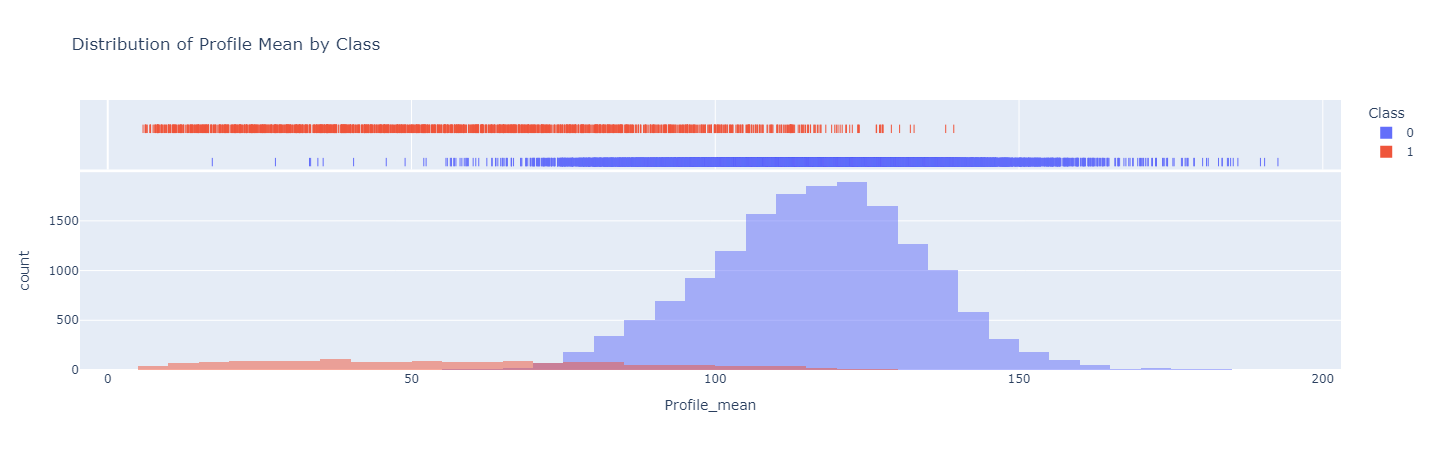

In [79]:
fig = px.histogram(
    df,
    x='Profile_mean',
    color='Class',
    barmode='overlay',
    nbins=50,
    marginal='rug',
    title='Distribution of Profile Mean by Class'
)
Image("figures/profile_mean_distribution.png")



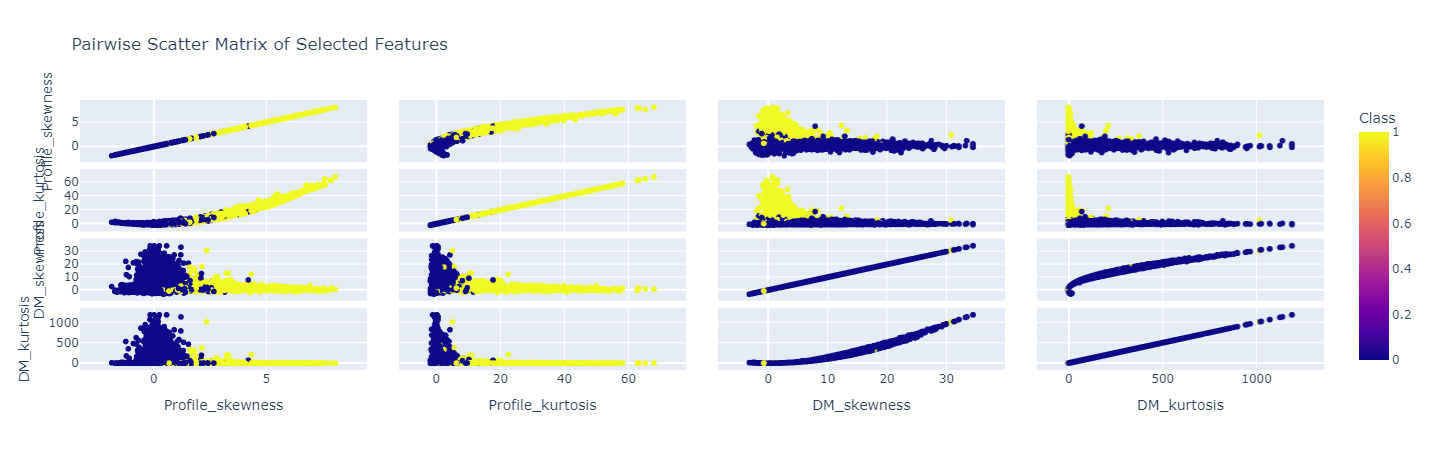

In [80]:
features = ['Profile_skewness', 'Profile_kurtosis', 'DM_skewness', 'DM_kurtosis']
fig = px.scatter_matrix(
    df,
    dimensions=features,
    color='Class',
    title='Pairwise Scatter Matrix of Selected Features'
)

Image("figures/Scatter_Matrix.png")

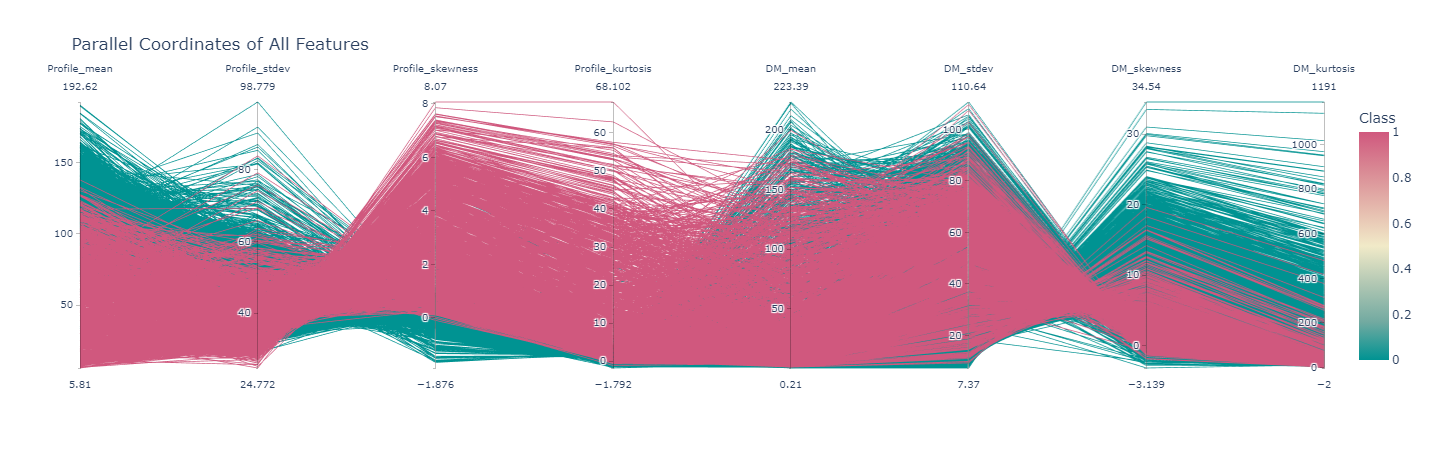

In [81]:
fig = px.parallel_coordinates(
    df,
    dimensions=[
        'Profile_mean','Profile_stdev','Profile_skewness','Profile_kurtosis',
        'DM_mean','DM_stdev','DM_skewness','DM_kurtosis'
    ],
    color='Class',
    color_continuous_scale=px.colors.diverging.Tealrose,
    title='Parallel Coordinates of All Features'
)
Image("figures/parallel_coordinates.png")

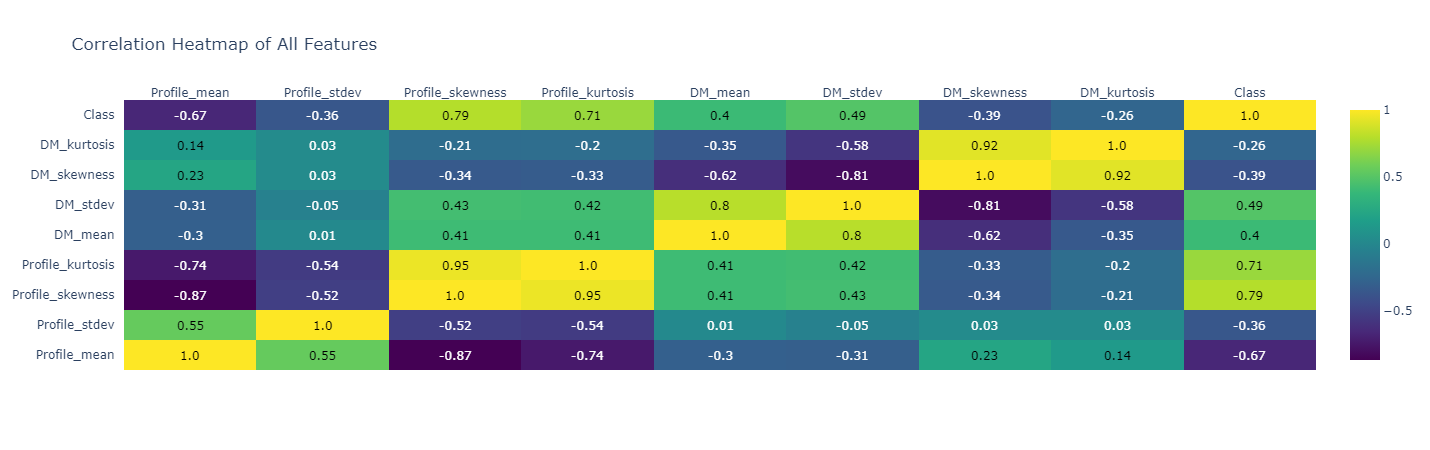

In [82]:
corr = df.corr()
z = np.round(corr.values, 2)

fig = ff.create_annotated_heatmap(
    z=z,
    x=corr.columns.tolist(),
    y=corr.columns.tolist(),
    annotation_text=z.astype(str),
    showscale=True,
    colorscale='Viridis'
)
fig.update_layout(title='Correlation Heatmap of All Features')
Image("figures/Heatmap.png")

Profile_skewness and Profile_kurtosis are closely correlated with class and with each other.

In [83]:
print(df.isnull().sum().sum())

0


No null values in data

In [84]:
y = df['Class']
X = df.drop('Class',axis=1)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=62)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (12528, 8)
X_test shape: (5370, 8)
y_train shape: (12528,)
y_test shape: (5370,)


In [85]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

np.mean(cross_val_score(SGDClassifier(loss='hinge', penalty='elasticnet', alpha=0.001, shuffle=True, random_state=62), X_train, y_train, cv=5))

0.9687882654483531

Stochastic Gradient Descent achieved approximately 96.88% accuracy through 5-fold cross-validation, which is impressive given that the data was unscaled and the hyperparameters were not yet optimized. Next, I will apply feature scaling and use GridSearchCV to find the model's optimal hyperparameters.

In [86]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
np.mean(cross_val_score(SGDClassifier(loss='hinge', penalty='elasticnet', alpha=0.001, shuffle=True, random_state=62), X_scaled, y_train, cv=5))

0.9782882439430797

Scaling the data improves the accuracy to 97.83%

In [87]:
from sklearn.model_selection import GridSearchCV
alpha_params = [0.00003, 0.0001, 0.0003, 0.0005, 0.0007, 0.001]

param_grid = {
    'alpha': np.linspace(0.0003, 0.0007, 15),
    'loss': ['hinge','log_loss','huber'],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'l1_ratio': np.linspace(0.005, 0.05, 10)
}

grid = GridSearchCV(SGDClassifier(random_state=62, shuffle=True), param_grid, cv=5, scoring='accuracy')

grid.fit(X_scaled, y_train)

print("Best parameters:", grid.best_params_)
print("Best score:", grid.best_score_)

Best parameters: {'alpha': 0.00035714285714285714, 'l1_ratio': 0.025000000000000005, 'loss': 'hinge', 'penalty': 'elasticnet'}
Best score: 0.9798051462916147


GridSearch was performed multiple times and achieved a score of 97.98%.
Best loss function was hinge, resulting in an SVM.
Best parameters: {'alpha': 0.00036, 'l1_ratio': 0.025, 'loss': 'hinge', 'penalty': 'elasticnet'}

Lets see how the model performs on the test set

In [88]:
from sklearn.metrics import accuracy_score
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)

SGD = SGDClassifier(loss='hinge', penalty='elasticnet',l1_ratio=0.025, alpha=0.00036, shuffle=True, random_state=62).fit(X_scaled,y_train)
y_pred = SGD.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

0.9770949720670391

Achieved a test score of of 97.71%. Trying XGBoost to see if it performs better.

In [89]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

grid = GridSearchCV(estimator=xgb,
                    param_grid=param_grid,
                    scoring='accuracy',
                    cv=5,
                    n_jobs=-1,
                    verbose=1)

grid.fit(X_scaled, y_train)

print("Best Parameters:", grid.best_params_)
print("Best Score:", grid.best_score_)

y_pred = grid.predict(X_test_scaled)
print(f"Test Score: {accuracy_score(y_test, y_pred)}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}
Best Score: 0.9807629433869691
Test Score: 0.9783985102420857


c:\Users\rowek\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[18:52:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




XGBoost Classifier achieved a training accuracy of 98.08% and a test accuracy of 97.84%